## Neural Network

As we know, perceptron is a linear model that is hard to give a proper solution for non-linear problem. Therefore, based on the common perceptron, we can extend the structure of the perceptron, and make the perceptron fit nonlinear problems by adding hidden layers. This perceptron model containing a hidden layer structure is a neural network, also called a multilayer perceptron.

<img src="1.png" />

Here is a two-layer network, that is, a single hidden layer network as an example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [2]:
# data generation function
def create_dataset():
    np.random.seed(1)
    # data size
    m = 400
    # number of instance for every label
    N = int(m/2)
    # data dimension
    D = 2
    # data matrix
    X = np.zeros((m, D))
    # label dimension
    Y = np.zeros((m, 1), dtype='uint8')
    a = 4

    for j in range(2):
        ix = range(N*j, N*(j+1))
        # theta
        t = np.linspace(j*3.12, (j+1)*3.12, N) + np.random.randn(N)*0.2  
        # radius
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T
    return X, Y

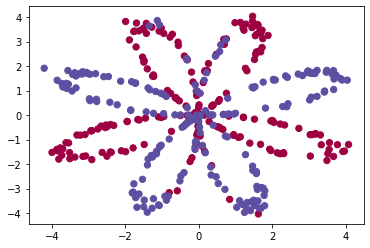

In [3]:
X, Y = create_dataset()
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral)

### Define the Network Structure
Assuming that $X$ is the input feature matrix of neural network, $y$ is the label vector, then the structure of a neural network with a single hidden layer is defined as follows:

In [4]:
def layer_sizes(X, Y):
    # input layer
    n_x = X.shape[0] 
    # hidden layer
    n_h = 4
    # output layer
    n_y = Y.shape[0] 
    return (n_x, n_h, n_y)

The size of input layer and output layer are related with the shape of $X$ and $y$, while the size of hidden layer needs to be specified manually (here is 4).

### Initialize Model Parameters
Suppose $W_1$ is the weight array from the input layer to the hidden layer, $b_1$ is the bias array from the input layer to the hidden layer; $W_2$ is the weight array from the hidden layer to the output layer, and $b_2$ is the bias array from the hidden layer to the output layer. So we define the parameter initialization function as follows:

In [5]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

### Forward Propagation
After the network structure is defined and parameter initialization is finished, it is time to start the training process of the neural network. The first step of training is forward propagation calculation. Suppose the activation function of the hidden layer is the tanh function, and the activation function of the output layer is the sigmoid function. Then the forward propagation calculation is expressed as:
$$
\begin{gathered}
z^{[1](i)}=W^{[1]} x^{(i)}+b^{[1](i)} \\
a^{[1](i)}=\tanh \left(z^{[1](i)}\right) \\
z^{[2](i)}=W^{[2]} a^{[1](i)}+b^{[2](i)} \\
\hat{y}^{(i)}=a^{[2](i)}=\text{sigmoid}\left(z^{[2](i)}\right)
\end{gathered}
$$

In [16]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = np.dot(W1, X) + b1 
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2 
    A2 = sigmoid(Z2)
    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

Get the respective parameters from the parameter initialization dictionary, then perform a forward propagation calculation, and save the result of the forward propagation calculation to the cache dictionary.

### Calculate the Current Training Loss
After the forward propagation calculation is completed, we need to compute the loss between the output of the calculation with the current parameters and the label value. The loss function is the cross-entropy loss:
$$
J=-\frac{1}{m} \sum_{i=0}^{m}\left(y^{(i)} \log \left(a^{[2](i)}\right)+\left(1-y^{(i)}\right) \log \left(1-a^{[2](i)}\right)\right)
$$

In [7]:
def compute_cost(A2, Y, parameters):
    # training sample size
    m = Y.shape[1]
    # compute cross-entropy loss
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = -1/m * np.sum(logprobs)
    # compress dimension
    cost = np.squeeze(cost)

    assert(isinstance(cost, float))
    return cost

### Backward Propagation
After the forward propagation and the loss are determined, it is necessary to continue the back propagation process to adjust the weights, which involves the gradient calculation of each parameter.
$$
\begin{array}{l|l}
d z^{[2]}=a^{[2]}-y & d Z^{[2]}=A^{[2]}-Y \\
d W^{[2]}=d z^{[2]} a^{[1]^{T}} & d W^{[2]}=\frac{1}{m} d Z^{[2]} A^{[1]^{T}} \\
d b^{[2]}=d z^{[2]} & d b^{[2]}=\frac{1}{m} n p . \text { sum }\left(d Z^{[2]}, \text { axis }=1, \text { keepdims }=\text { True }\right) \\
d z^{[1]}=W^{[2] T} d z^{[2]} * g^{[1]}\left(z^{[1]}\right) & d Z^{[1]}=W^{[2] T} d Z^{[2]} * g^{[1]}\left(Z^{[1]}\right) \\
d W^{[1]}=d z^{[1]} x^{T} & d W^{[1]}=\frac{1}{m} d Z^{[1]} X^{T} \\
d b^{[1]}=d z^{[1]} & d b^{[1]}=\frac{1}{m} n p . s u m\left(d Z^{[1]}, \text { axis }=1, \text { keepdims }=\text { True }\right)
\end{array}
$$

In [8]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2-Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True) 
    dZ1 = np.dot(W2.T, dZ2)*(1-np.power(A1, 2)) 
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}    
    return grads

### Update Weights
According to the result from backward propagation to update the weights
$$
\theta=\theta-\alpha \frac{\partial J}{\partial \theta}
$$

In [9]:
def update_parameters(parameters, grads, learning_rate=1.2):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 -= dW1 * learning_rate
    b1 -= db1 * learning_rate
    W2 -= dW2 * learning_rate
    b2 -= db2 * learning_rate

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

After the neural network training process is deployed, each module is combined to define a neural network model:

In [10]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    # loop for gradient descent and parameter update
    for i in range(0, num_iterations):
        # forward propagation
        A2, cache = forward_propagation(X, parameters)
        # compute current loss
        cost = compute_cost(A2, Y, parameters)
        # backward propagation
        grads = backward_propagation(parameters, cache, X, Y)
        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate=1.2)
        # print loss
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters


In [11]:
# prediction function based on training result
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters) 
    predictions = (A2>0.5)
    return predictions

In [17]:
# test model
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220598
Cost after iteration 8000: 0.219392
Cost after iteration 9000: 0.218480


In [18]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%
